# fig8_prec
AR composites of daily precipitation (mm/day)


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

### ERA5 renalysis


In [4]:
## Set variable names (for saving data/figs)
var_names = 'prec'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid 
# Tropics/Extratropics Domain
lonmin = 40.
lonmax = 120
latmin = 10.
latmax = 50.

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open HUV anomaly data
filepath_pattern = path_to_data + 'ERA5/prec/daily/out.era5_hma_025dg_daily_prec_*.nc'
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
# f2

# Create new dataset to rename lat lon
ds = xr.Dataset({'prec': (['time', 'lat', 'lon'], f2['mtpr'].values*86400)},
                      coords={'time': (['time'], f2.time.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


ds size in GB 6.04



In [5]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
era = ds.sel(time=idx)

era

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 3520)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-28T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
Data variables:
    prec     (time, lat, lon) float64 3.834 3.554 2.671 ... 1.423 0.4868 1.161

### SALLJ days

In [20]:
filepath = path_to_out + 'HUV250QUV850t0120-1565corhma_AR-types-djf.csv'
df = pd.read_csv(filepath)
df

,Unnamed: 0,AR_CAT,EOF_CAT,EOF_CAT1,EOF_CAT2
0,1979-12-01 09:00:00,1,0,0,0
1,1979-12-02 09:00:00,1,0,0,0
2,1979-12-03 09:00:00,0,0,0,0
3,1979-12-04 09:00:00,0,0,0,0
4,1979-12-05 09:00:00,0,0,0,0
...,...,...,...,...,...
3515,2018-02-24 09:00:00,0,0,0,0
3516,2018-02-25 09:00:00,0,0,0,0
3517,2018-02-26 09:00:00,2,0,0,0
3518,2018-02-27 09:00:00,0,0,0,0


In [7]:
# Combine AR Cat data w/ reanalysis data

# Add llj time series to the ERA dataset
era['ar'] = ('time', df.AR_CAT)
era['eof'] = ('time', df.EOF_CAT)
era = era.set_coords('ar')
era = era.set_coords('eof')

# Select only LLJ days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

# Select only LLJ days
idx = (era.eof >= 1)
era_eof = era.sel(time=idx)

# print results
print(era_eof)

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
    ar       (time) int64 1 1 1 1 1 1 1 1 1 2 2 1 1 ... 1 1 1 1 1 1 1 2 2 2 2 2
    eof      (time) int64 0 0 0 0 0 0 0 2 1 1 0 2 0 ... 1 2 1 1 1 1 1 2 2 1 0 0
Data variables:
    prec     (time, lat, lon) float64 3.834 3.554 2.671 ... 21.49 17.73 15.02
<xarray.Dataset>
Dimensions:  (lat: 161, lon: 321, time: 236)
Coordinates:
  * time     (time) datetime64[ns] 1980-02-26T09:00:00 ... 2017-12-05T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
    ar       (time) int64 1 1 2 1 2 2 1 1 1 1 1 2 2 ... 1 1 1 1 1 1 1 1 1 2 2 2
    eof      (time) int64 2 1 1 2 1 1 1 

### Composites of AR types

In [8]:
# Compute composites of each AR type
era_ar_comp = era_ar.groupby('ar').mean('time')
print(era_ar_comp)

era_eof_comp = era_eof.groupby('eof').mean('time')
print(era_eof_comp)


<xarray.Dataset>
Dimensions:  (ar: 2, lat: 161, lon: 321)
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
  * ar       (ar) int64 1 2
Data variables:
    prec     (ar, lat, lon) float64 1.459 1.439 1.497 ... 3.648 3.612 3.318
<xarray.Dataset>
Dimensions:  (eof: 2, lat: 161, lon: 321)
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 10.75 10.5 10.25 10.0
  * lon      (lon) float32 40.0 40.25 40.5 40.75 ... 119.25 119.5 119.75 120.0
  * eof      (eof) int64 1 2
Data variables:
    prec     (eof, lat, lon) float64 1.625 1.623 1.639 ... 3.762 3.418 3.008


## Figure 8

### Common plot properties

In [9]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)


### Create figure

In [16]:
# lat/lon arrays
lats = era_ar_comp.lat.values
lons = era_ar_comp.lon.values

# precip
prec = era_ar_comp.prec.values
print(prec.min(), prec.max())

# Labels
plt_labels = ['AR Type 1', 'AR Type 2']

-7.298103598661201e-06 32.985230821829575


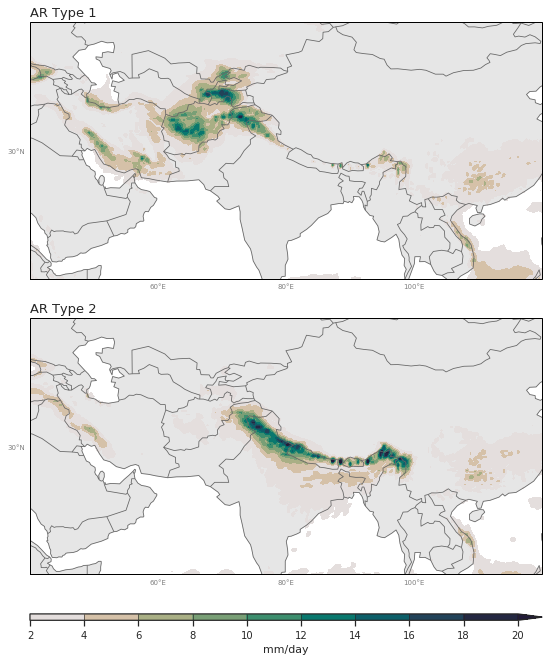

In [17]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
    clevs = np.arange(2,22,2)
    cf = ax.contourf(lons, lats, prec[k,:,:], transform=datacrs,
                    levels=clevs,cmap=cmo.rain, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('mm/day', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'ar_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    

In [18]:
# precip
prec = era_eof_comp.prec.values
print(prec.min(), prec.max())

# Labels
plt_labels = ['AR EOF 1', 'AR EOF 2']

-4.296742596672577e-06 22.838704635326128


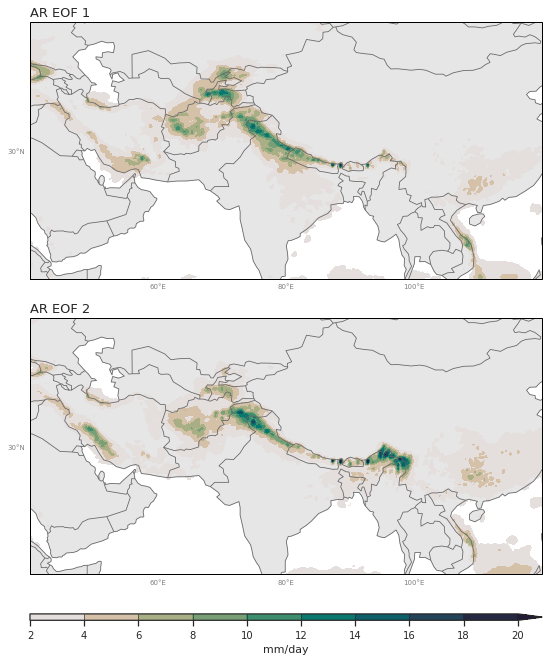

In [19]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
    clevs = np.arange(2,22,2)
    cf = ax.contourf(lons, lats, prec[k,:,:], transform=datacrs,
                    levels=clevs,cmap=cmo.rain, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('mm/day', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'eof_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    